# Application of pyFAI to Synchrotron Serial Crystallography (SSX)

In [1]:
%matplotlib nbagg

In [2]:
import os, sys, posixpath, shutil, glob
import numpy
from matplotlib.pyplot import subplots
import scipy.optimize
from scipy.special import erf
import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.opencl.peak_finder import OCL_PeakFinder

print(pyFAI.version)

0.21.0


In [3]:
# Image from an insulin dataset provided by Decris to advertize for their detector.
img = UtilsTest.getimage("Pilatus6M.cbf")
data = fabio.open(img).data

<IPython.core.display.Javascript object>


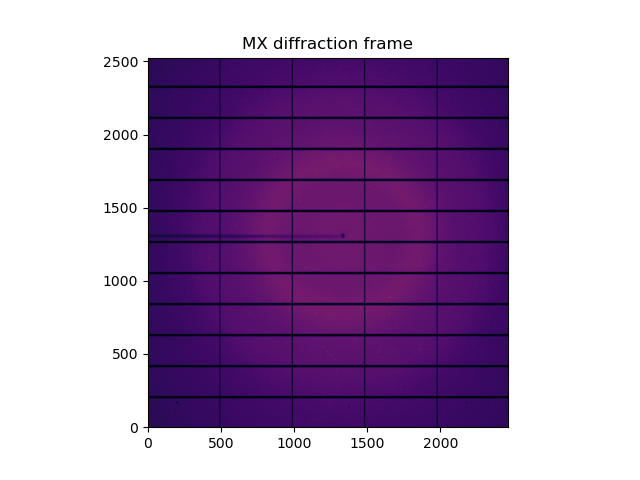

In [4]:
ax = jupyter.display(data)
_ = ax.set_title("MX diffraction frame")

## Azimuthal averaging



In [5]:
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
ai

Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.033200e-10m
SampleDetDist= 3.000000e-01m	PONI= 2.254060e-01, 2.285880e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 300.000mm	Center: x=1329.000, y=1310.500 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

<IPython.core.display.Javascript object>


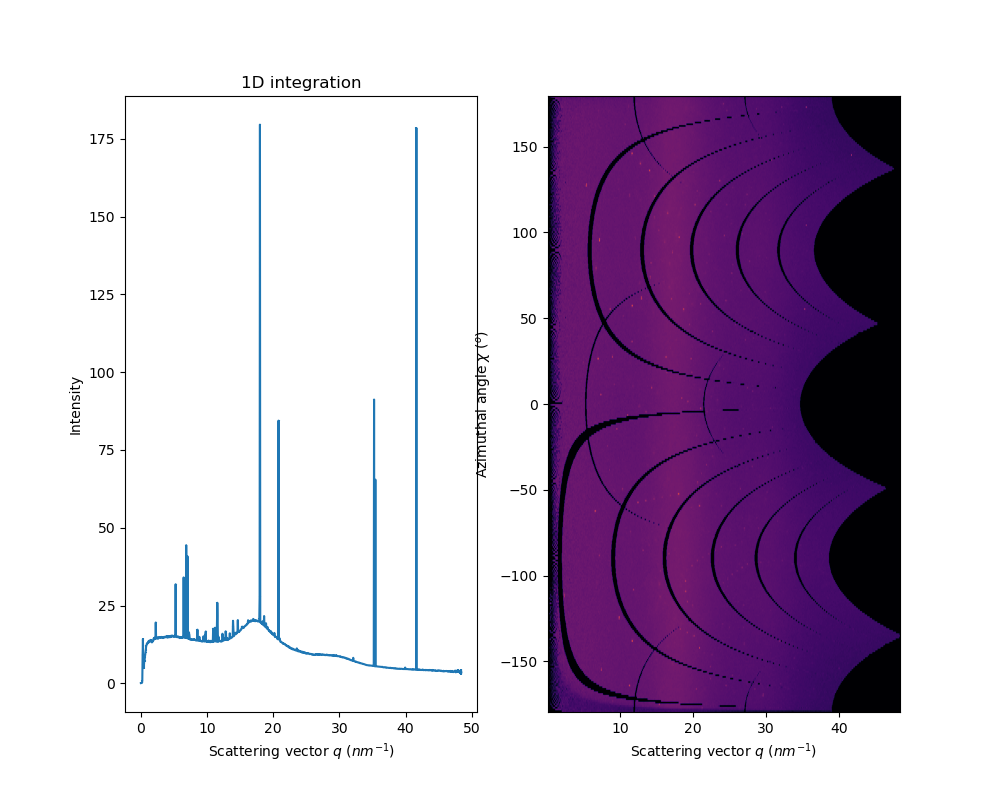

In [6]:
npt = 1000
mask = data<0
ai.detector.mask = mask
res1d = ai.integrate1d(data, npt, method=("no", "csr", "cython"), error_model="poisson")
res2d = ai.integrate2d(data, npt, method=("no", "csr", "cython"))

fig,ax = subplots(1, 2, figsize=(10,8))
jupyter.plot1d(res1d, ax=ax[0])
jupyter.plot2d(res2d, ax=ax[1])
pass

<IPython.core.display.Javascript object>


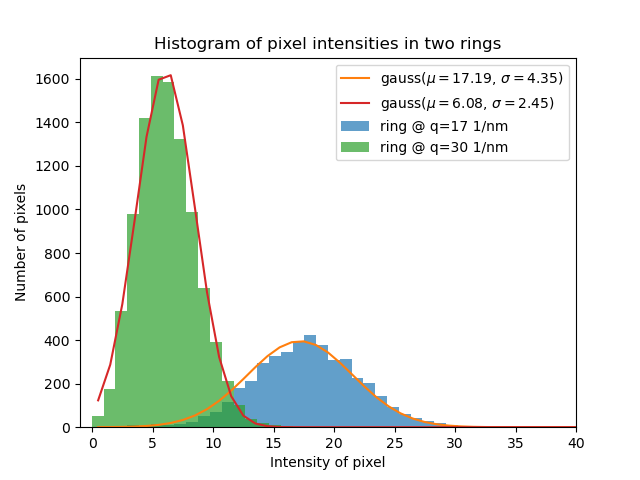

Text(0.5, 1.0, 'Histogram of pixel intensities in two rings')

In [7]:
targets = 17, 30

fig, ax = subplots()
def gaussian(x, h, c, s):
    return h*numpy.exp(-(x-c)**2/(2*s*s))

for target in targets:
    idx = numpy.argmin(abs(target-res1d.radial))    
    key = list(ai.engines.keys())[0]
    csr = ai.engines[key].engine.lut
    values = data.ravel()[csr[1][csr[2][idx]:csr[2][idx+1]]]
    ax.hist(values, 42, range=(-1, 40), label=f"ring @ q={target} 1/nm", alpha=0.7)
    values = values[values>=0]
    v,c = numpy.histogram(values, values.max())
    c = numpy.argmax(v)
    s=1
    h = v.max()
    x = numpy.arange(values.max())+0.5 
    res = scipy.optimize.curve_fit(gaussian, x, v, [h,c,s])[0]
    ax.plot(x, gaussian(x, *res), label=r"gauss($\mu=$%.2f, $\sigma=$%.2f)"%(res[1], res[2]))
ax.set_xlim(-1, 40)
ax.legend()
ax.set_ylabel("Number of pixels")
ax.set_xlabel("Intensity of pixel")
ax.set_title(f"Histogram of pixel intensities in two rings")

In [8]:
# Numerical histogram of the last curve:
numpy.histogram(values, values.max())

(array([  52,  175,  533,  977, 1420, 1614, 1584, 1323,  987,  640,  390,
         210,  104,   39,   20,    9,    5,    2,    1,    2,    0,    0,
           0,    0,    1,    0,    1,    0,    1,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76

Pixel counting 84, 63, 58 and 52 are likely to be outsiders! 

If one considered the ensemble of pixels falling into a single azimuthal bin to follow the normal distrinution, here with an average of 6 and an associated deviation of 2.5, Any pixel above 15 should be considered a bragg-peak !

<IPython.core.display.Javascript object>


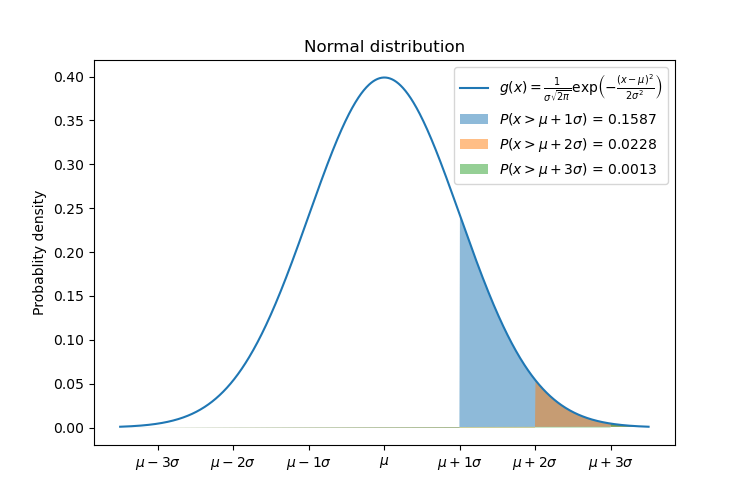

<ipython-input-9-77d69db61fcd>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f(k) for k in range(-4,5)])


In [9]:
#Some properties of the Normal distribution:
fig, ax = subplots(1, 1, figsize=(7.5,5))

x = numpy.linspace(-3.5, 3.5, 1001)
g = lambda x: numpy.exp(-x*x/2)/numpy.sqrt(2*numpy.pi)
ax.plot(x, g(x), label=r"$g(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$")
f=lambda k: "$\mu"+(str(k)+"\sigma$" if k<0 else ("+"+str(k)+"\sigma$" if k>0 else "$"))
ax.set_xticklabels([f(k) for k in range(-4,5)])
y1 = g(x)
for t in range(1,4):
    y1[x<t] = 0
    ax.fill(x, y1, alpha=0.5, label=f"$P(x>\mu+{t}\sigma)$ = {0.5*(1-erf(t/numpy.sqrt(2))):6.4f}")
ax.set_ylabel("Probablity density")
ax.set_title("Normal distribution")
ax.legend(loc=1)
pass

## Sigma-clipping

The technic consists in *iteratively* rejecting outliers in a distribution and re-evaluate the mean/std until it is stable. This actually enforces a normal distribution in the remaining data-points.

<IPython.core.display.Javascript object>


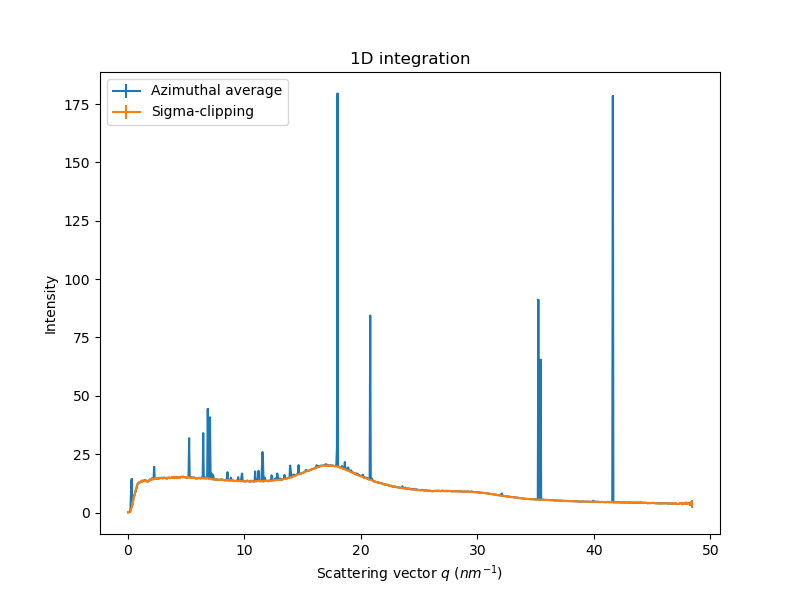

In [10]:
ai.detector.mask = mask
sc1d = ai.sigma_clip_ng(data, npt, method=("no", "csr", "cython"), error_model="azimuthal")

fig,ax = subplots(1, figsize=(8, 6))
jupyter.plot1d(res1d, ax=ax, label="Azimuthal average")
jupyter.plot1d(sc1d, ax=ax, label="Sigma-clipping")
pass

Sigma-clipping provides us with a smooth background and the associated uncertainty. There are 2 main parameters:
* the number of iteration of clipping (often 3 to 5)
* the cut-off for disarding pixels. We use an adaptative Chauvenet threshold which depends on the size of the distibution, usually between 3 and 5.

There are 2 ways of calculating the deviation:
* from the Poisson statistics
* from the deviation to the mean

The later has been developped for detector being non-poissonian, like the Jungdrau which is an integrating detector.

## Application to the sparsification of MX/SSX data

When data cannot be written to disk because of the data-deluge, why not saving only the intensity of Bragg-peaks ?!

In [11]:
method = res1d.method
lut = ai.engines[method].engine.lut
peak_finder = OCL_PeakFinder(lut, 
                             image_size=numpy.prod(ai.detector.shape),
                             unit=res1d.unit,
                             bin_centers=res1d.radial,
                             radius=ai.array_from_unit(unit=res1d.unit),
                             mask=ai.detector.mask)

%time sep = peak_finder(data, error_model="azimuthal")
print(f"Number of Bragg pixels found: {len(sep.index)}")

CPU times: user 1.82 ms, sys: 885 µs, total: 2.7 ms
Wall time: 19 ms
Number of Bragg pixels found: 16706


<IPython.core.display.Javascript object>


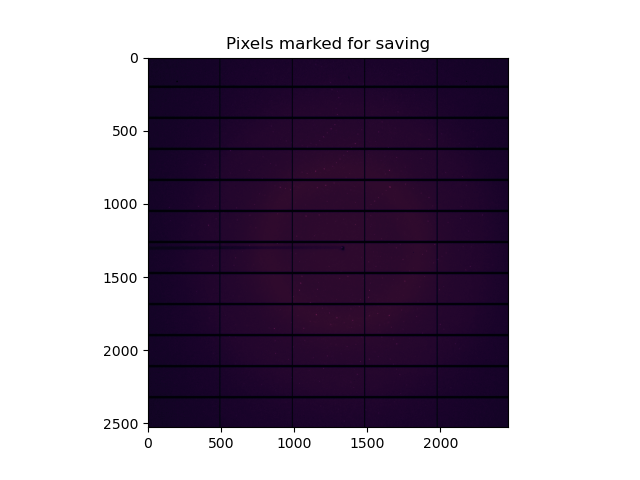

In [12]:
ax = jupyter.display(data)
_ = ax.set_title("Pixels marked for saving")
lmask = numpy.ones(data.size, dtype=bool)
lmask[sep[0]]=0
shadow = numpy.outer(lmask, numpy.array([0, 0, 0, 150], dtype=numpy.uint8)).reshape(data.shape+(4,))
ax.imshow(shadow)

### Application for the compression of an SSX dataset:

You will find the needed data in this directory:
https://www.silx.org/pub/pyFAI/pyFAI_UM_2022/SSX/

The parameters used to compress 1000 frames of an Eiger4M are:
* The exerimental geometry and the mask for the detector
* 1000 azimuthal bins
* An azimuthal error model
* The cut-off for harvesting pixels is 2 sigma, thus 2% of background pixels should be picked as well
* Polarization factor of 0.99
which make the following command line:

```
sparsify-Bragg -p geometry.poni -m mask.msk -P 0.99 --bins 1000 -b ID29 --cutoff-pick 2 --error-model azimuthal --noise 0.1 -o lysozyme_azim.h5 lysozyme_Gd_4_1_data_000001.h5
```

The compression factor obtained is here 6.5x, the speed is about 40 fps when reading data via a 1Gbit NFS link. Compression speeds of 500 to 1000 fps were measured when treating data in memory.

Data can be densified again with:
```
densify-Bragg lysozyme_azim.h5 -o lysozyme_dense.h5
```
The densification takes place at ~100fps while reading and writing depend mostly on the type of drive.



## Application to the peak extraction of MX/SSX data

Instead of saving pixel, one could perform the peak integration, in the same way as `PeakFinder8` does:

### *PeakFinder8*
The *peakfinder8* is the core algorithm for assessing the quality of a single frame in serial crystallography and was initially implemented in C++ within the [cheetah](https://www.desy.de/~barty/cheetah/Cheetah/SFX_hitfinding.html) [1]

This algorithm is called *peakfinder8* because it consits of 8 subsequent steps perfromed on evry single frame:

1. perfrom the azimuthal integration with uncertainety propagation
2. discard pixels which differ by more than N-sigma from the mean and cycle to 1 about 3 to 5 times
3. pick all pixels with I > mean + min(N*sigma, noise)
4. such pixel is a peak if it is the maximum of the 3x3 or 5x5 patch and there are *connected* pixels in the patch with their intensity above the previous threshold.
5. subtract background and sum the signal over the patch
6. return the index of the peak, the integrated signal and the center of mass of the peak
7. exclude neighboring peaks (un-implemented)
8. Validate the frame if there are enough peaks found.

There is a attempt to implement *peakfinder8* on GPU within the pyFAI.
The steps 1+2 correspond to the sigma-clipping algorithm and enforce an azimuthal, normal distribution for the background.

This algorithm has a python wrapper available from https://github.com/tjlane/peakfinder8


[1] A. Barty, R. A. Kirian, F. R. N. C. Maia, M. Hantke, C. H. Yoon, T. A. White, and H. N. Chapman, "Cheetah: software for high-throughput reduction and analysis of serial femtosecond x-ray diffraction data", J Appl Crystallogr, vol. 47, pp. 1118-1131 (2014)



In [13]:
#Installation of a local copy of the Cython-bound peakfinder8
targeturl = "https://github.com/tjlane/peakfinder8"
targetdir = posixpath.split(targeturl)[-1]
if os.path.exists(targetdir):
    shutil.rmtree(targetdir, ignore_errors=True)
pwd = os.getcwd()
try:
    os.system("git clone " + targeturl)
    os.chdir(targetdir)
    os.system(sys.executable + " setup.py build")    
finally:
    os.chdir(pwd)
sys.path.append(pwd+"/"+glob.glob(f"{targetdir}/build/lib*")[0])
from ssc.peakfinder8_extension import peakfinder_8

In [14]:
#Create some compatibility layer:
img = data.astype("float32")
r = ai._cached_array['q_center'].astype("float32")
imask = (1-mask).astype("int8")
max_num_peaks = 10000
asic_nx = img.shape[-1]
asic_ny = img.shape[0]
nasics_x = 1
nasics_y = 1
adc_threshold = 2.0
minimum_snr = 3.0
min_pixel_count = 9
max_pixel_count = 999
local_bg_radius = 2
accumulated_shots = 1
min_res = 0
max_res = 3000


In [15]:
%%time 
ref = peakfinder_8(max_num_peaks,
                   img, imask, r, 
                   asic_nx, asic_ny, nasics_x, nasics_y, 
                   adc_threshold, minimum_snr,
                   min_pixel_count, max_pixel_count, local_bg_radius)

CPU times: user 154 ms, sys: 1.08 ms, total: 155 ms
Wall time: 155 ms


In [16]:
print("Number of peak found: ", len(ref[0]), len(ref[1]), len(ref[2]))

Number of peak found:  189 189 189


<IPython.core.display.Javascript object>


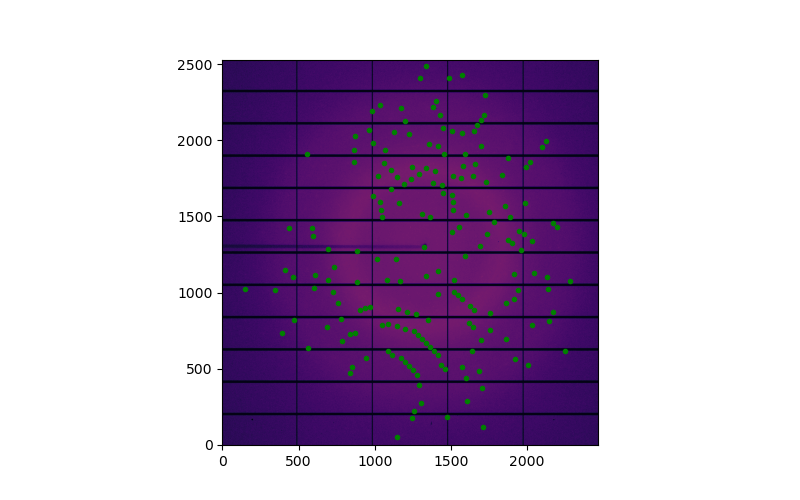

In [17]:
#Display the peaks
fig, ax = subplots(figsize=(8,5))
jupyter.display(data, ax=ax)
ax.plot(ref[0], ref[1], ".g")
pass

In [18]:
### Peakfinder applied in 

In [19]:
unit = res1d.unit
integrator = ai.setup_CSR(ai.detector.shape, 1000, mask=mask, unit=unit, split="no", scale=False)
pf = OCL_PeakFinder(lut, 
                    image_size=data.size,
                    bin_centers=res1d.radial,
                    radius=ai._cached_array[unit.name.split("_")[0] + "_center"],
                    mask=mask,
#                      block_size=512,
                    unit=unit) 
kwargs = {"data": data, 
          "error_model":"azimuthal", 
         }
print(f"Number of high intensity pixels at stage #3: {pf.count(**kwargs ,cycle=5, cutoff_pick=3.0)}\n\
Number of peaks identified at stage #6: {pf._count8(**kwargs, cycle=5, cutoff_pick=3.0)}")

Number of high intensity pixels at stage #3: 16714
Number of peaks identified at stage #6: 342


In [20]:
# Visualization of the performances:
res8 = pf.peakfinder8(data, error_model="azimuthal", cycle=5, cutoff_pick=3, noise=2, connected=5, patch_size=7)
print(len(res8), res8.dtype)

240 [('index', '<i4'), ('intensity', '<f4'), ('sigma', '<f4'), ('pos0', '<f4'), ('pos1', '<f4')]


<IPython.core.display.Javascript object>


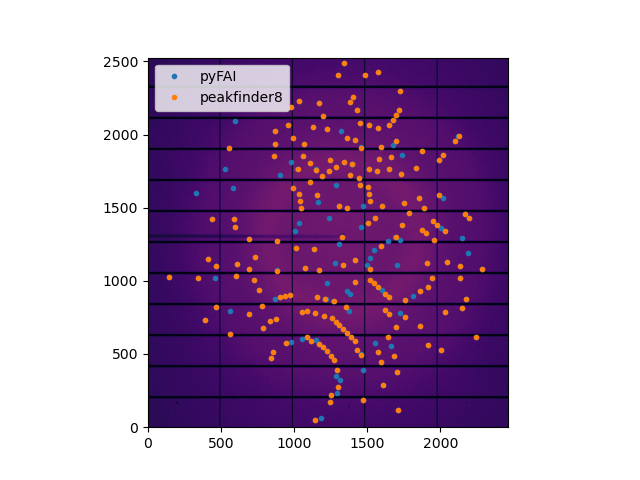

In [21]:
ax = jupyter.display(data)
ax.plot(res8["pos1"], res8["pos0"], ".", label="pyFAI")
ax.plot(ref[0], ref[1], ".", label="peakfinder8")
_=ax.legend()

In [22]:
# Performance measurement:
pf.reset_log()
pf.set_profiling(True)
%time pf.peakfinder8(**kwargs, cycle=5, cutoff_pick=3, noise=2, connected=5, patch_size=7)
print("\n".join(pf.log_profile(True)))
pf.set_profiling(False)

CPU times: user 2.32 ms, sys: 960 µs, total: 3.28 ms
Wall time: 23 ms

OpenCL kernel profiling statistics in milliseconds for: OCL_PeakFinder
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw H->D image (    1):    2.604    2.604    2.604    2.604    0.000
                                 cast s32_to_float (    1):    0.654    0.654    0.654    0.654    0.000
                                         memset_ng (    1):    0.001    0.001    0.001    0.001    0.000
                                       corrections (    1):    2.064    2.064    2.064    2.064    0.000
                                   csr_sigma_clip4 (    1):   10.525   10.525   10.525   10.525    0.000
                                    memset counter (    1):    0.001    0.001    0.001    0.001    0.000
                                       peakfinder8 (    1):    4.079    4.079    4.079    4.079    0.000
                  

### Application of the peakfinder on SSX data:

As previously, one can perform the peak-picking for the serial-crystallophy dataset:
```
peakfinder -p geometry.poni -m mask.msk -P 0.99 --bins 1000 -b ID29 --cutoff-pick 3 --error-model azimuthal --noise 0.1 -o lysozyme_pf_azim.h5 --patch-size 5 --connected 3 lysozyme_Gd_4_1_data_000001.h5
```
